<a href="https://colab.research.google.com/github/juan-villa02/medical_vqa_vlm/blob/main/code/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQA Model - BERT + ResNet18

## Libraries/Dependencies

In [1]:
# # Install dependencies for local running
# !pip install torch
# !pip install torchvision
# !pip install PIL
# !pip install skimage
# !pip install scipy
# !pip install transformers
!pip install bertviz
# !pip install seaborn
# !pip install matplotlib
# !pip install numpy
# !pip install tqdm
# !pip install zipfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [2]:
# PyTorch framework
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as utils
# Image and mask handling
from PIL import Image
from skimage import transform
import scipy.io as sio
# Transformers (Hugginface)
from transformers import AutoTokenizer, BertForQuestionAnswering, VisualBertModel, VisualBertForQuestionAnswering, VisualBertConfig
# Attention visualization
#from bertviz import head_view
import seaborn as sns
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Extra dependencies
import json
import os
from tqdm import tqdm
import zipfile
from google.colab import files

In [3]:
# Set training device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Paths & Data Extraction

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path_dir = '.'
path_dir = '/content/drive/MyDrive/TFG Juan Villanueva/databases_qa.zip'

In [6]:
# Data folder
data_folder = './data/'

In [7]:
# ISIC_2016 database
train_ISIC_path = 'databases_qa/ISIC_2016'

In [8]:
# def filter_json(json_file, images_dir, output_file):
#    filtered_data = []

#    with open(json_file, 'r') as f:
#        data = json.load(f)

#        for item in data:
#            image_id = item['image_id'] + '.jpg'
#            image_path = os.path.join(images_dir, image_id)

#            # Check if the image file exists
#            if os.path.exists(image_path):
#                filtered_data.append(item)

#    # Write the filtered data to the output JSON file
#    with open(output_file, 'w') as f:
#        json.dump(filtered_data, f, indent=4)

#    return

In [9]:
# json_file = '/content/data/databases_qa/ISIC_2016/qa_ISIC.json'
# images_dir = '/content/data/databases_qa/ISIC_2016/images/ISBI2016_ISIC_Part1_Test_Data_orig'
# output_file = 'qa_filtered_ISIC.json'
# filter_json(json_file, images_dir, output_file)

In [10]:
# ISIC_2016 database (images and masks)
train_extra_ISIC_path = 'ISBI2016_ISIC_Part3_Training_Data_orig'

In [11]:
# Pizarro database (images)
pizarro_path = 'databases_qa/pizarro'

In [12]:
# Function to extract databases from the main zip file
def extract_databases(zip_path, extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [13]:
# Extract all databases from the main zip file
if path_dir != '.':
  extract_databases(path_dir, data_folder)

In [14]:
# ISIC_2016 images
database1_path = os.path.join(data_folder, train_ISIC_path)

In [15]:
# Pizarro images
# 500 imágenes; Las 46 primeras son más complejas, en cuanto a diagnóstico. (Entrega 1) El resto están más equilibradas (Entrega 2-5)
database2_path = os.path.join(data_folder, pizarro_path)

## VQA Dataset - Images, Masks, & QA

In [16]:
# Dataset class to load images and questions
class VQADataset(Dataset):
    def __init__(self, data_dir, json_file, tokenizer=None, transform=None, extraPath=None):
        self.data_dir = data_dir
        self.images_dir = os.path.join(self.data_dir, 'images')
        self.masks_dir = os.path.join(self.data_dir, 'masks')

        # Handle special ISIC data folder
        self.extraPath = extraPath
        if self.extraPath is not None:
            self.images_dir = os.path.join(self.images_dir, self.extraPath)
            self.masks_dir = os.path.join(self.masks_dir, self.extraPath)

        self.transform = transform
        self.tokenizer = tokenizer

        with open(json_file, 'r') as f:
            self.data = json.load(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        item = self.data[idx]
        image_path = os.path.join(self.images_dir, item['image_id'])

        # Ensure the image ID ends with ".jpg"
        if not image_path.endswith(".jpg"):
            image_path += ".jpg"

        # Check if the image is available
        try:
          image = Image.open(image_path).convert('RGB')

          # Case 1: Pizarro dataset
          if self.extraPath is None:
            mask_id = item['image_id'].split('.')[0]
            mask_name = 'L' + mask_id + '.pgm'
            mask_path = os.path.join(self.masks_dir, mask_name)
            mask = Image.open(mask_path)

          # Case 2: ISIC dataset
          else:
            mask_path = os.path.join(self.masks_dir, item['image_id']) + '_Segmentation.png'
            mask = Image.open(mask_path)

          if self.transform:
              image, mask = self.transform((image, mask))

          # Store questions and answers in two different arrays
          qa_pairs = item['qa_pairs']
          questions = [qa['question'] for qa in qa_pairs]
          answers = [qa['answer'] for qa in qa_pairs]

        except FileNotFoundError as e:

          image = None
          mask = None
          questions = None
          answers = None

        return image, mask, questions, answers

## Load pre-trained ResNet18

In [17]:
# Load ResNet-18 model from .pth file
def load_resnet(path, optimizer=None, scheduler=None):
    resnet = models.resnet18()
    # Remove final fully connected layer and avg pooling (we do not want the model to return labels but features with dimension)
    resnet.fc = nn.Identity()
    resnet.avgpool = nn.Identity()

    # Load the weights
    state_dict = torch.load(path, map_location=device)['state_dict']

    # Remove unexpected keys if they exist
    unexpected_keys = ['fc.weight', 'fc.bias']
    for key in unexpected_keys:
        if key in state_dict:
            del state_dict[key]

    # Load the weights
    resnet.load_state_dict(state_dict)
    resnet.eval()

    if optimizer is not None:
        optimizer.load_state_dict(torch.load(path)['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(path)['scheduler'])

    resnet.to(device)

    return resnet, optimizer, scheduler

In [18]:
model_source_path = '/content/drive/MyDrive/TFG Juan Villanueva/codigo diagnostico/bestdiagNet.pth'

In [19]:
resnet, optimizer, scheduler = load_resnet(model_source_path)

In [20]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Image Transformations

In [21]:
class CropByMask(object):
    """Recortamos la imagen usando la máscara de la lesión.

    Args:
        border (tupla o int): El borde de recorte alrededor de la máscara. Es sabido que el análisis del borde
        de la lesión con la piel circudante es importante para los dermatólogos, por lo que puede ser interesante
        dejar una guarda.
        Si es una tupla, entonces es (bordery,borderx)
    """

    def __init__(self, border):
        assert isinstance(border, (int, tuple))
        if isinstance(border, int):
            self.border = (border,border)
        else:
            self.border = border

    def __call__(self, sample):

        image, mask = np.array(sample[0]), np.array(sample[1])

        h, w = image.shape[:2]
        #Calculamos los índices del bounding box para hacer el cropping
        sidx=np.nonzero(mask)
        minx=np.maximum(sidx[1].min()-self.border[1],0)
        maxx=np.minimum(sidx[1].max()+1+self.border[1],w)
        miny=np.maximum(sidx[0].min()-self.border[0],0)
        maxy=np.minimum(sidx[0].max()+1+self.border[1],h)
        #Recortamos la imagen
        image=image[miny:maxy,minx:maxx,...]
        mask=mask[miny:maxy,minx:maxx]

        return image, mask

In [22]:
class Rescale(object):
    """Rescales the image to a desired size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is the output_size.
            If int, the smaller of the image edges is matched to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):

        image_np, mask_np = sample[0], sample[1]

        # Get the height and width of the image
        h, w = image_np.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        # Resize the image using scikit-image's resize function
        resized_image = transform.resize(image_np, (new_h, new_w))
        resized_mask = transform.resize(mask_np, (new_h, new_w))

        # Convert the resized NumPy array back to a PIL image
        resized_image_pil = Image.fromarray((resized_image * 255).astype(np.uint8))
        resized_mask_pil = Image.fromarray((resized_mask * 255).astype(np.uint8))

        #return resized_image_pil, resized_mask_pil
        return resized_image, resized_mask

In [23]:
class CenterCrop(object):
    """Crop the central area of the image

    Args:
        output_size (tupla or int): Crop size. If int, square crop

    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):

        image, mask = sample[0], sample[1]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        rem_h = h - new_h
        rem_w = w - new_w

        if h>new_h:
            top = int(rem_h/2)
        else:
            top=0

        if w>new_w:
            left = int(rem_w/2)
        else:
            left = 0

        image = image[top: top + new_h,
                     left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]


        return image, mask

In [24]:
class ToTensor(object):
    """Converts the image ndarray to a tensor."""

    def __call__(self, sample):

        image, mask = sample[0], sample[1]
        # Change the axes
        # numpy image: H x W x C
        # torch image: C x H x W
        # image = np.array(image)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)

        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze(0)

        return image, mask


In [25]:
class Normalize(object):
    """Normalizes the image by subtracting the mean and dividing by the standard deviations.

    Args:
        mean: The vector containing the means.
        std: The vector containing the standard deviations.
    """

    def __init__(self, mean, std):
        assert len(mean) == len(std), 'Length of mean and std vectors is not the same'
        self.mean = np.array(mean)
        self.std = np.array(std)

    def __call__(self, sample):

        image, mask = sample[0], sample[1]

        # c, h, w = image.shape
        # assert c==len(self.mean), 'Length of mean and image is not the same'

        dtype = image.dtype
        mean = torch.as_tensor(self.mean, dtype=dtype, device=image.device)
        std = torch.as_tensor(self.std, dtype=dtype, device=image.device)
        # Normalize the image
        # image = (image - mean[:, None, None]) / std[:, None, None]
        image.sub_(mean[:, None, None]).div_(std[:, None, None])

        return image, mask

In [26]:
# ISIC Dataset------------------------------------------------------------
dataset_isic = VQADataset(data_dir=database1_path,
                           json_file='/content/data/databases_qa/ISIC_2016/qa_filtered_ISIC.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            CropByMask(15),
                            Rescale(224),
                            CenterCrop(224),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]),
                            extraPath=train_extra_ISIC_path)

In [27]:
# Pizarro Dataset------------------------------------------------------------
dataset_pizarro = VQADataset(data_dir=database2_path,
                           json_file='/content/data/databases_qa/pizarro/qa_pizarro.json',
                           tokenizer=None,
                           transform=transforms.Compose([
                            CropByMask(15),
                            Rescale(224),
                            CenterCrop(224),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                            ]))

In [28]:
# Split into training and test (no validation dataset since the optimal training parameters
# are suggested in the VisualBert paper) -> 80% train, 20% test
train_size_isic = int(0.8 * len(dataset_isic))
test_size_isic = len(dataset_isic) - train_size_isic
train_size_pizarro = int(0.8 * len(dataset_pizarro))
test_size_pizarro = len(dataset_pizarro) - train_size_pizarro

In [29]:
# Set the random seed for reproducibility
torch.manual_seed(42)
# Split the ISIC dataset into training and testing subsets
train_dataset_isic, test_dataset_isic = random_split(dataset_isic, [train_size_isic, test_size_isic])
# Split the Pizarro dataset into training and testing subsets
train_dataset_pizarro, test_dataset_pizarro = random_split(dataset_pizarro, [train_size_pizarro, test_size_pizarro])

## Define the all the possible answers within both datasets

In [37]:
# Extract all answers from both datasets
all_answers_pizarro = [answer for _, _, _, answers in train_dataset_pizarro for answer in answers]
all_answers_isic = [answer for _, _, _, answers in train_dataset_isic for answer in answers]
all_answers_pizarro_test = [answer for _, _, _, answers in test_dataset_pizarro for answer in answers]
all_answers_isic_test = [answer for _, _, _, answers in test_dataset_isic for answer in answers]
# Combine answers from both datasets
all_answers_combined = all_answers_pizarro + all_answers_isic + all_answers_pizarro_test + all_answers_isic_test
# Obtain unique answer values
unique_answers = list(set(all_answers_combined))

In [38]:
unique_answers

['The global pattern of the lesion is mixed (mix of two of the above).',
 'The histology diagnostic indicates non-atypical stable mole (m).',
 'The diagnostic impression is melanoma.',
 'The histology diagnostic indicates spitz nevus (sn).',
 'The diagnostic difficulty level is low.',
 'The lesion is asymmetric on one axis.',
 ' peripheral globules are observed.',
 'Yes, subtle gray regression is observed.',
 'The global pattern of the lesion is multicomponent (mix of 3 or more above).',
 'The global pattern of the lesion is undefined.',
 'No peripheral projections are present.',
 'The general silhouette of the lesion is flattened elevated.',
 'The lesion is symmetric.',
 'No gray regression is observed.',
 'Yes, subtle homogeneous area with vessels is observed.',
 'Yes, clear peripheral globules are observed.',
 'No chrysalis is observed.',
 'Yes, clear chrysalis is observed.',
 'The histology diagnostic indicates reed nevus (nr).',
 'Yes, clear and dominant negative reticulum is obse

In [39]:
# Create dictionaries id2label and label2id
id2label = {i: label for i, label in enumerate(unique_answers)}
label2id = {label: i for i, label in enumerate(unique_answers)}

In [40]:
id2label

{0: 'The global pattern of the lesion is mixed (mix of two of the above).',
 1: 'The histology diagnostic indicates non-atypical stable mole (m).',
 2: 'The diagnostic impression is melanoma.',
 3: 'The histology diagnostic indicates spitz nevus (sn).',
 4: 'The diagnostic difficulty level is low.',
 5: 'The lesion is asymmetric on one axis.',
 6: ' peripheral globules are observed.',
 7: 'Yes, subtle gray regression is observed.',
 8: 'The global pattern of the lesion is multicomponent (mix of 3 or more above).',
 9: 'The global pattern of the lesion is undefined.',
 10: 'No peripheral projections are present.',
 11: 'The general silhouette of the lesion is flattened elevated.',
 12: 'The lesion is symmetric.',
 13: 'No gray regression is observed.',
 14: 'Yes, subtle homogeneous area with vessels is observed.',
 15: 'Yes, clear peripheral globules are observed.',
 16: 'No chrysalis is observed.',
 17: 'Yes, clear chrysalis is observed.',
 18: 'The histology diagnostic indicates reed 

In [41]:
# Required tensor with the label IDs
answers_ids_tensor = torch.arange(len(id2label), dtype=torch.float, device=device)
answers_ids_tensor

tensor([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
         24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
         36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
         48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
         60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
         72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
         84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
         96.,  97.,  98.,  99., 100., 101., 102., 103.], device='cuda:0')

In [42]:
# Train Dataloaders
train_pizarro_dataloader = DataLoader(train_dataset_pizarro, batch_size=5, shuffle=True)
train_isic_dataloader = DataLoader(train_dataset_isic, batch_size=5, shuffle=True)
# Test Dataloaders
test_pizarro_dataloader = DataLoader(test_dataset_pizarro, batch_size=5, shuffle=True)
test_isic_dataloader = DataLoader(test_dataset_isic, batch_size=5, shuffle=True)

In [43]:
# Auxiliary function to visualize a batch
def show_batch(sample_batched):
    """Show a batch of images."""

    # Store images, questions and answers
    images_batch, masks_batch, questions_batch, answers_batch = \
            sample_batched[0], sample_batched[1], sample_batched[2], sample_batched[3]

    # Identify the batch size to define the grid
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    # Generate the grid
    grid = utils.make_grid(images_batch)

    # Convert to numpy and denormalize
    grid = grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.show()

0 [('How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?'), ('Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?'), ('Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.'), ('What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?'), ('What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patt

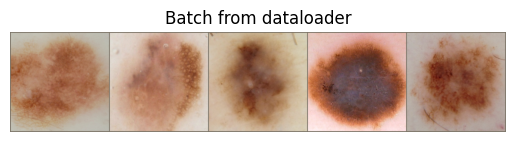

1 [('How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?', 'How is the global pattern?'), ('Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?', 'Can you describe the overall pattern?'), ('Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.', 'Describe the pattern observed globally.'), ('What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?', 'What is the pattern like throughout the lesion?'), ('What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patterns are present in the entire lesion?', 'What patt

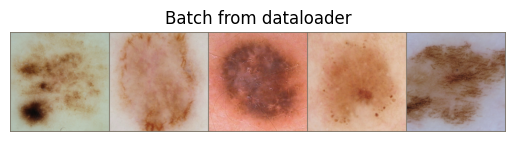

In [44]:
# Iterate over the dataloader and visualize batches
for i_batch, sample_batched in enumerate(train_isic_dataloader):
    print(i_batch, sample_batched[2])
    show_batch(sample_batched)

    # Show only the data of the 3rd batch and stop.
    if i_batch == 1:
        break

## Image Feature Extraction

In [45]:
def extract_image_features(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    num_samples = len(dataloader.dataset)

    output_shape = (7,7,512) # Keep dimensionality of outputs (layer 4)

    # Calculate the total number of features
    num_features = np.prod(output_shape)

    features = np.zeros((num_samples, *output_shape), dtype=np.float32)
    sample_idx = 0

    with torch.no_grad():
        for sample in dataloader:
            # Get images
            inputs = sample[0].to(device).float()

            # Forward pass
            outputs = model(inputs)

            outputs_reshaped = outputs.reshape(outputs.size(0), *output_shape)

            # Store features
            batch_size = inputs.size(0)
            # features[sample_idx:sample_idx + batch_size, :] = outputs_flat.cpu().numpy()
            features[sample_idx:sample_idx + batch_size, :] = outputs_reshaped.cpu().numpy()
            sample_idx += batch_size

    return torch.tensor(features, device=device)

In [46]:
# Function to print GPU memory usage
def print_gpu_memory():
    print(f"Memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Memory reserved: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

## VQA Model Creation

In [47]:
class VQAModel(nn.Module):
    def __init__(self, resnet, vlm, tokenizer):
        super(VQAModel, self).__init__()

        # Pre-trained ResNet model
        self.resnet = resnet
        # Vision Language Model
        self.vlm = vlm
        # Tokenizer
        self.tokenizer = tokenizer
        # Freeze parameters of the ResNet model
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, image_features, question, labels_idxs=None, training=False):

        # image_features -> array with visual features for the specific image (7x7x512)
        # question -> individual question within the image batch
        # labels_idx -> tensor with shape (0, ..., num_labels-1)
        # training; boolean to determine the mode (train/evaluation)

        # Prepare image inputs -> (batch_size, visual_seq_length, visual_embedding_dim)
        flattened_embedding = image_features.view(-1, 512) # (49x512)
        visual_embeds = flattened_embedding.unsqueeze(0) # (1x49x512)

        # Token type and attention masks -> (batch_size, visual_seq_length)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long, device=device)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.float, device=device)

        # Tokenize question
        tokenized_question = self.tokenizer(question,
                                            return_token_type_ids=True,
                                            return_attention_mask=True,
                                            add_special_tokens=True,
                                            return_tensors='pt')

        # Input for the VLM model (refer to VisualBert to understand the shapes)
        input_dict = {
            "visual_embeds": visual_embeds,
            "visual_token_type_ids": visual_token_type_ids,
            "visual_attention_mask": visual_attention_mask,
            "input_ids": tokenized_question['input_ids'].to(device),
            "token_type_ids": tokenized_question['token_type_ids'].to(device),
            "attention_mask": tokenized_question['attention_mask'].to(device),
        }

        # Training mode: track gradients
        if training:

            output = self.vlm(**input_dict, labels=labels_idxs)
            logits = output.logits
            loss = output.loss
            attentions = output.attentions

            del output

        # Evaluation mode: no gradients
        else:
            with torch.no_grad():
                output = self.vlm(**input_dict, labels=labels_idxs)
                logits = output.logits
                loss = output.loss
                attentions = output.attentions

        # # Check for memory usage
        # print_gpu_memory()

        return logits, loss, attentions

### Define LLM & Tokenizer

In [48]:
# Pre-trained base case for VQA provided in documentation
# tokenizer = AutoTokenizer.from_pretrained("deepset/bert-base-cased-squad2")
# bertModel = BertForQuestionAnswering.from_pretrained("deepset/bert-base-cased-squad2")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
# Modify the visual embedding config so that size of the features matches
configuration = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa",
                                                 visual_embedding_dim=512,
                                                 num_labels=answers_ids_tensor.shape[0],
                                                 output_attentions=True)
visualBert = VisualBertForQuestionAnswering(configuration)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/153k [00:00<?, ?B/s]

## Training Loop

In [49]:
# Create the VQA Model and pass it to the GPU
vqa_model = VQAModel(resnet, visualBert, tokenizer)

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vqa_model.to(device)

VQAModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [51]:
# Define hyperparameters
learning_rate = 5e-5
num_epochs = 10

In [52]:
# Define optimizer
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, vqa_model.parameters()), lr=learning_rate)

In [53]:
# Extract all image features for the dataloaders
with torch.no_grad():
    # Train
    image_features_isic = extract_image_features(vqa_model.resnet, train_isic_dataloader)
    image_features_pizarro = extract_image_features(vqa_model.resnet, train_pizarro_dataloader)
    # Test
    image_features_isic_test = extract_image_features(vqa_model.resnet, test_isic_dataloader)
    image_features_pizarro_test = extract_image_features(vqa_model.resnet, test_pizarro_dataloader)

In [54]:
# Train
image_features_dataloaders = [image_features_isic, image_features_pizarro]
dataloaders = [train_isic_dataloader, train_pizarro_dataloader]
# Test
image_features_dataloaders_test = [image_features_isic_test, image_features_pizarro_test]
dataloaders_test = [test_isic_dataloader, test_pizarro_dataloader]

### Backward pass per question

In [55]:
# def train(model, dataloaders, image_features_dataloaders, num_epochs, optimizer, id2label, label2id):

#     # Set the model in training mode
#     model.train()

#     # Loss function
#     lossCriteria = nn.CrossEntropyLoss()

#     # Start training
#     for epoch in range(num_epochs):
#         total_loss = 0.0
#         num_batches = 0

#         #text_results = []

#         # Train for each dataloader
#         for data_idx in range(len(dataloaders)):

#             # Select dataloader and image features
#             dataloader = dataloaders[data_idx]
#             image_features = image_features_dataloaders[data_idx]

#             print(f'Dataset number: {data_idx + 1}')
#             print()

#             for images, masks, questions, answers in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):

#                 # Track batch loss
#                 batch_loss = 0.0

#                 # Transpose questions and answers
#                 questions = np.transpose(questions)
#                 answers = np.transpose(answers)
#                 # Store shape for iteration
#                 num_images, num_questions_per_image = np.shape(questions)

#                 # Iterate over all questions for each image
#                 for image_idx in range(num_images):
#                   for question_idx in range(num_questions_per_image):

#                     # Avoid using previous gradients
#                     optimizer.zero_grad()

#                     #Forward pass
#                     outputs, _, _ = model(image_features[image_idx], questions[image_idx,question_idx], answers_ids_tensor, training=True)

#                     # Prediction + Ground truth (ID)
#                     #outputs = outputs.unsqueeze(0)
#                     target_index = label2id[answers[image_idx, question_idx]]
#                     target = torch.tensor([target_index], device=device)

#                     # Compute classification loss
#                     loss = lossCriteria(outputs, target)

#                     # Backpropagation
#                     loss.backward()
#                     optimizer.step()

#                     batch_loss += loss.item() / (num_images * num_questions_per_image)

#                     # Remove unnecessary tensors from memory
#                     del loss

#                 # Print batch loss
#                 print(f"Batch Loss: {batch_loss}")

#                 # Accumulate the total loss and num of batches
#                 total_loss += batch_loss
#                 num_batches += 1

#         # Average training loss for the epoch
#         avg_loss = total_loss / num_batches
#         print(f"Epoch {epoch + 1}, Average Loss: {avg_loss}")

#         # Save trained model after each epoch
#         torch.save(vqa_model.state_dict(), os.path.join('/content/drive/MyDrive/TFG Juan Villanueva/', f'trained_vqa_model2_crossEntropy_epoch{epoch+1}.pth'))

### Backward pass per image (all questions)

In [56]:
def train(model, dataloaders, dataloaders_test, image_features_dataloaders, image_features_dataloaders_test, num_epochs, optimizer, id2label, label2id):

    # Set the model in training mode
    model.train()

    # Loss function
    lossCriteria = nn.CrossEntropyLoss()

    # Epochs loss
    train_epoch_losses = []
    test_epoch_losses = []

    # Start training
    for epoch in range(num_epochs):
        total_loss = 0.0
        num_batches = 0

        # Train for each dataloader
        for data_idx in range(len(dataloaders)):

            # Select dataloader and image features
            dataloader = dataloaders[data_idx]
            image_features = image_features_dataloaders[data_idx]

            print(f'Dataset number: {data_idx + 1}')
            print()

            for images, masks, questions, answers in tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):

                # Track batch loss
                batch_loss = 0.0

                # Transpose questions and answers
                questions = np.transpose(questions)
                answers = np.transpose(answers)
                # Store shape for iteration
                num_images, num_questions_per_image = np.shape(questions)

                # Iterate over all questions for each image
                for image_idx in range(num_images):

                  # Avoid using previous gradients
                  optimizer.zero_grad()

                  # Store questions loss
                  image_losses = []

                  for question_idx in range(num_questions_per_image):

                    #Forward pass
                    outputs, _, _ = model(image_features[image_idx], questions[image_idx,question_idx], answers_ids_tensor, training=True)

                    # Prediction + Ground truth (ID)
                    target_index = label2id[answers[image_idx, question_idx]]
                    target = torch.tensor([target_index], device=device)

                    # Compute classification loss for the question and store it
                    loss = lossCriteria(outputs, target)
                    image_losses.append(loss)


                  # Aggregate losses for all questions within the same image
                  total_image_loss = torch.stack(image_losses).sum() / num_questions_per_image

                  # Add to batch loss
                  batch_loss += total_image_loss.item() / num_images

                  # Backpropagation
                  total_image_loss.backward()
                  optimizer.step()

                  del total_image_loss, image_losses

                # Print batch loss
                print(f"Batch Loss: {batch_loss}")

                # Accumulate the total loss and num of batches
                total_loss += batch_loss
                num_batches += 1

        # Average training loss for the epoch
        avg_loss = total_loss / num_batches
        train_epoch_losses.append(avg_loss)

        # Average test loss for the epoch
        _, avg_test_loss = test(model, dataloaders_test, image_features_dataloaders_test, id2label, label2id)
        test_epoch_losses.append(avg_test_loss)

        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_loss}")
        print(f"Epoch {epoch + 1}, Average Testing Loss: {avg_test_loss}")

        # Save trained model after each epoch
        torch.save(vqa_model.state_dict(), os.path.join('/content/drive/MyDrive/TFG Juan Villanueva/', f'trained_vqa_model4_imageLoss_epoch{epoch+1}.pth'))

    return train_epoch_losses, test_epoch_losses

### Test function (no gradients)

In [57]:
def test(model, dataloaders, image_features_dataloaders, id2label, label2id):
    # Set the model in evaluation mode
    model.eval()

    # List to store results (by dataset)
    results = [[] for _ in range(len(dataloaders))]

    lossCriteria = nn.CrossEntropyLoss()

    total_loss = 0.0
    num_batches = 0

    # Iterate over datasets
    for data_idx in range(len(dataloaders)):
        dataloader = dataloaders[data_idx]
        image_features = image_features_dataloaders[data_idx]

        print(f'Testing dataset number: {data_idx + 1}\n')

        batch_idx = 0

        for images, masks, questions, answers in tqdm(dataloader, desc=f'Testing dataset {data_idx + 1}', unit='batch'):

            batch_results = []
            batch_loss = 0.0

            # Transpose questions and answers
            questions = np.transpose(questions)
            answers = np.transpose(answers)

            num_images, num_questions_per_image = np.shape(questions)

            # Iterate over all questions for each image
            for image_idx in range(num_images):

                total_image_loss = 0.0

                for question_idx in range(num_questions_per_image):

                    # Forward pass
                    with torch.no_grad():
                        outputs, _, _ = model(image_features[image_idx], questions[image_idx, question_idx], answers_ids_tensor, training=False)

                    # Get predicted label
                    probabilities = torch.softmax(outputs, dim=-1)
                    pred_idx = torch.argmax(probabilities, dim=-1)
                    pred_label = id2label[pred_idx.item()]

                    # Get ground truth label
                    true_label = answers[image_idx, question_idx]
                    target_index = label2id[true_label]
                    target = torch.tensor([target_index], device=device)

                    # Compute loss and store it
                    loss = lossCriteria(outputs, target)

                    # Add to average image loss
                    total_image_loss += loss.item() / num_questions_per_image

                    del loss

                    # # Convert attention tensors to lists
                    # attentions_list = [layer.tolist() for layer in attentions]

                    # Store results
                    batch_results.append({
                        "Batch ID": batch_idx,
                        "Image ID": image_idx,
                        "Question": questions[image_idx, question_idx],
                        "Ground Truth": true_label,
                        "Prediction": pred_label
                        #"Attention": attentions_list  # 12x1x12x57x57 (Layer x Num Obs. x Attention Head x Input Features x Input Features)
                    })

                batch_loss += total_image_loss / num_images

            # Loss contribution of the batch for the total loss
            total_loss += batch_loss
            num_batches +=1

            # Store batch results
            results[data_idx].append(batch_results)

            # Increment batch index
            batch_idx += 1

    avg_loss = total_loss / num_batches

    return results, avg_loss

### Initialize training

In [58]:
# train_epoch_losses, test_epoch_losses = train(vqa_model, dataloaders, dataloaders_test, image_features_dataloaders, image_features_dataloaders_test, num_epochs, optimizer, id2label, label2id)

### Loss tracking and model selection

In [59]:
# train_epoch_losses

In [60]:
# test_epoch_losses

In [61]:
# # Generate x-axis values (epochs)
# epochs = range(1, len(train_epoch_losses) + 1)
# # Plotting
# plt.plot(epochs, train_epoch_losses, 'orange', label='Train Loss')
# plt.plot(epochs, test_epoch_losses, 'b', label='Validation Loss')
# # Adding labels and title
# plt.title('Train and Validation Loss per Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# # Display the plot
# plt.show()

## Testing - Metrics

It is really important that the id2label dictionary keeps the index order as in the optimal training process

In [62]:
id2label = {0: 'The global pattern of the lesion is undefined.',
 1: 'The lesion appears to be malignant.',
 2: 'The diagnostic difficulty level is low.',
 3: 'Yes, clear and dominant undefined area is observed.',
 4: 'Yes, clear and dominant negative reticulum is observed.',
 5: 'Yes, subtle homogeneous area without vessels is observed.',
 6: 'Yes, clear small dots/globules are present.',
 7: 'The histology diagnostic indicates non-atypical stable mole (m).',
 8: 'The general silhouette of the lesion is exophytic.',
 9: 'The presence of dysplasia is .',
 10: 'Yes, clear and dominant large globules/cobblestone are observed.',
 11: 'No homogeneous area with vessels is observed.',
 12: 'The lesion appears to be benign.',
 13: 'The histology diagnostic indicates lentiginous melanocytic nevus (lmn).',
 14: 'Yes, clear peripheral globules are observed.',
 15: 'The diagnostic impression is exclude melanoma.',
 16: 'Yes, subtle negative reticulum is observed.',
 17: 'The peripheral globular pattern is regular conventional.',
 18: 'Yes, clear and dominant homogeneous area with vessels is observed.',
 19: 'Yes, clear and dominant peripheral globules are observed.',
 20: 'The histology diagnostic indicates junctional melanocytic nevus (jmn).',
 21: 'The peripheral globular pattern is irregular bursting.',
 22: ' large globules/cobblestone are observed.',
 23: 'Yes, clear homogeneous area without vessels is observed.',
 24: 'The histology diagnostic indicates superficial spreading melanoma (ssm).',
 25: 'Yes, clear whitish blue veil is observed.',
 26: 'No peripheral globules are observed.',
 27: 'Yes, clear and dominant pigmented reticulum is observed.',
 28: 'No large globules/cobblestone are observed.',
 29: 'The lesion has been not excised.',
 30: 'The global pattern of the lesion is mixed (mix of two of the above).',
 31: 'Yes, clear large globules/cobblestone are observed.',
 32: 'No whitish blue veil is observed.',
 33: 'No negative reticulum is observed.',
 34: 'The lesion has been first consultation.',
 35: 'The lesion is asymmetric on one axis.',
 36: 'The diagnostic impression is melanoma.',
 37: 'The diagnostic impression is spitz/reed nevus.',
 38: 'The global pattern of the lesion is diffuse reticular.',
 39: 'Yes, subtle pigmented reticulum is observed.',
 40: 'No small dots/globules are present.',
 41: 'The peripheral globular pattern is focal conventional.',
 42: ' chrysalis is observed.',
 43: 'The peripheral globular pattern is irregular conventional.',
 44: 'The lesion is symmetric.',
 45: 'No homogeneous area without vessels is observed.',
 46: 'The histology diagnostic indicates compound melanocytic nevus (cmn).',
 47: 'Yes, subtle gray regression is observed.',
 48: 'Yes, clear and dominant peripheral projections are present.',
 49: 'The lesion has been follow-up with previous dermoscopy, due to symptoms.',
 50: 'Yes, clear pigmented reticulum is observed.',
 51: 'Yes, subtle undefined area is observed.',
 52: 'The diagnostic difficulty level is medium.',
 53: 'The global pattern of the lesion is homogeneous.',
 54: 'The histology diagnostic indicates intradermal melanocytic nevus (imn).',
 55: 'No undefined area is observed.',
 56: 'No pigmented reticulum is observed.',
 57: 'The lesion is asymmetric on two axes.',
 58: 'The diagnostic difficulty level is high.',
 59: 'Yes, subtle homogeneous area with vessels is observed.',
 60: 'The general silhouette of the lesion is flattened elevated.',
 61: 'Yes, clear gray regression is observed.',
 62: 'Yes, clear peripheral projections are present.',
 63: 'The diagnostic impression is atypical mole.',
 64: 'Yes, subtle large globules/cobblestone are observed.',
 65: 'Yes, clear and dominant small dots/globules are present.',
 66: 'Yes, subtle whitish blue veil is observed.',
 67: 'The lesion has been follow-up with previous dermoscopy, due to changes.',
 68: ' peripheral globules are observed.',
 69: 'Yes, clear and dominant homogeneous area without vessels is observed.',
 70: 'The peripheral globular pattern is focal bursting.',
 71: 'No gray regression is observed.',
 72: 'The histology diagnostic indicates dysplastic melanocytic nevus (dmn).',
 73: 'Yes, clear negative reticulum is observed.',
 74: 'Yes, subtle chrysalis is observed.',
 75: 'The peripheral globular pattern is absent.',
 76: 'The histology diagnostic indicates melanoma in situ (mis).',
 77: 'Yes, subtle peripheral projections are present.',
 78: 'The diagnostic impression is non-atypical mole.',
 79: 'Yes, subtle small dots/globules are present.',
 80: 'The presence of dysplasia is not available.',
 81: 'The presence of dysplasia is not applicable.',
 82: 'Yes, clear undefined area is observed.',
 83: 'Yes, clear homogeneous area with vessels is observed.',
 84: 'The peripheral globular pattern is .',
 85: 'The peripheral globular pattern is regular bursting.',
 86: 'The lesion has been follow-up, without previous dermoscopy.',
 87: 'The histology diagnostic indicates reed nevus (nr).',
 88: 'Yes, subtle peripheral globules are observed.',
 89: 'The general silhouette of the lesion is flat.',
 90: 'The global pattern of the lesion is cobblestone.',
 91: 'No chrysalis is observed.',
 92: 'The histology diagnostic indicates congenital melanocytic nevus (cmn).',
 93: 'The presence of dysplasia is severe.',
 94: 'No peripheral projections are present.',
 95: 'Yes, clear white regression is observed.',
 96: 'The global pattern of the lesion is multicomponent (mix of 3 or more above).',
 97: 'The global pattern of the lesion is globular.',
 98: 'No white regression is observed.',
 99: 'Yes, clear chrysalis is observed.',
 100: 'The global pattern of the lesion is patchy reticular.',
 101: 'Yes, subtle white regression is observed.',
 102: 'The histology diagnostic indicates spitz nevus (sn).',
 103: 'The lesion is .'}

In [63]:
label2id = {v: k for k, v in id2label.items()}

In [64]:
# Define a model instance
trainedVQAmodel = VQAModel(resnet, visualBert, tokenizer)
# Load trained model from Google Drive
model_path = '/content/drive/MyDrive/TFG Juan Villanueva/trained_vqa_model4_imageLoss_epoch8.pth'
try:
    state_dict = torch.load(model_path, map_location=device)
    # Assign the loaded state dictionary to the model
    trainedVQAmodel.load_state_dict(state_dict)
    print("Model loaded successfully!")
except FileNotFoundError:
    print(f"File not found at path: {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")

Model loaded successfully!


In [65]:
outputs_train, avg_train_loss = test(trainedVQAmodel, dataloaders, image_features_dataloaders, id2label, label2id)
outputs_test, avg_test_loss = test(trainedVQAmodel, dataloaders_test, image_features_dataloaders_test, id2label, label2id)

Testing dataset number: 1



Testing dataset 1: 100%|██████████| 71/71 [05:28<00:00,  4.63s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 80/80 [07:55<00:00,  5.94s/batch]


Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:21<00:00,  4.52s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [01:58<00:00,  5.93s/batch]


In [ ]:
outputs_train[0][0]

In [67]:
avg_train_loss

0.8432846824122531

In [ ]:
outputs_test[0][1]

In [75]:
def compute_accuracy(outputs):

    # Track overall accuracy
    total_correct = 0
    total_examples = 0
    # Dictionary to store metrics
    accuracy_per_dataset = {}

    # Iterate over both datasets
    for dataset_idx, dataset_outputs in enumerate(outputs):

        # Dataset i metrics
        dataset_correct = 0
        dataset_examples = 0

        for batch_outputs in dataset_outputs:
            for output in batch_outputs:
                dataset_examples += 1
                if output['Prediction'] == output['Ground Truth']:
                    total_correct += 1
                    dataset_correct += 1

        total_examples += dataset_examples
        # Store dataset metric (avoid division by zero by ensuring there are provided observations)
        accuracy_per_dataset[f'Dataset {dataset_idx+1}'] = dataset_correct / dataset_examples if dataset_examples > 0 else 0

    # Store overall metric (avoid division by zero by ensuring there are provided observations)
    accuracy_per_dataset['Overall'] = total_correct / total_examples if total_examples > 0 else 0

    return accuracy_per_dataset

In [76]:
accuracy_train = compute_accuracy(outputs_train)
accuracy_test = compute_accuracy(outputs_test)
print("Accuracy per dataset (Train):", accuracy_train)
print("Accuracy per dataset (Test):", accuracy_test)

Accuracy per dataset (Train): {'Dataset 1': 0.7587121212121212, 'Dataset 2': 0.6130681818181818, 'Overall': 0.6676846590909091}
Accuracy per dataset (Test): {'Dataset 1': 0.7545454545454545, 'Dataset 2': 0.6309090909090909, 'Overall': 0.6772727272727272}


### Baseline VisualBert + ResNet

In [80]:
# Baseline conigurations
baselineConfiguration = VisualBertConfig.from_pretrained("uclanlp/visualbert-vqa",
                                                 visual_embedding_dim=512,
                                                 num_labels=answers_ids_tensor.shape[0],
                                                 output_attentions=True)
baselineVisualBert = VisualBertForQuestionAnswering(baselineConfiguration)

In [ ]:
baselineModel = VQAModel(resnet, baselineVisualBert, tokenizer)
baselineModel.to(device)

In [86]:
outputs_baseline_train, avg_baseline_loss_train = test(baselineModel, dataloaders, image_features_dataloaders, id2label, label2id)
outputs_baseline_test, avg_baseline_loss_test = test(baselineModel, dataloaders_test, image_features_dataloaders_test, id2label, label2id)

Testing dataset number: 1



Testing dataset 1: 100%|██████████| 71/71 [05:28<00:00,  4.63s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 80/80 [07:59<00:00,  5.99s/batch]


Testing dataset number: 1



Testing dataset 1: 100%|██████████| 18/18 [01:21<00:00,  4.55s/batch]


Testing dataset number: 2



Testing dataset 2: 100%|██████████| 20/20 [01:59<00:00,  6.00s/batch]


In [87]:
accuracy_train_baseline = compute_accuracy(outputs_baseline_train)
accuracy_test_baseline = compute_accuracy(outputs_baseline_test)
print("Accuracy per dataset (Train):", accuracy_train_baseline)
print("Accuracy per dataset (Test):", accuracy_test_baseline)

Accuracy per dataset (Train): {'Dataset 1': 0.01090909090909091, 'Dataset 2': 0.007840909090909091, 'Overall': 0.008991477272727273}
Accuracy per dataset (Test): {'Dataset 1': 0.010303030303030303, 'Dataset 2': 0.008454545454545454, 'Overall': 0.009147727272727273}


## Model explainability (Attention heatmaps)

In [92]:
def extract_attentions(model, dataloader, image_features_dataloader, id2label, label2id, image_idx, question_idx):
    # Set the model in evaluation mode
    model.eval()

    for images, masks, questions, answers in dataloader:

        # Transpose questions and answers
        questions = np.transpose(questions)
        answers = np.transpose(answers)

        # Select image index and question index!
        image = images[image_idx]
        image_features = image_features_dataloader[image_idx]
        question = questions[image_idx, question_idx]

        # Forward pass
        with torch.no_grad():
            outputs, _, attentions = model(image_features, question, answers_ids_tensor, training=False)

            # Get predicted label
            probabilities = torch.softmax(outputs, dim=-1)
            pred_idx = torch.argmax(probabilities, dim=-1)
            pred_label = id2label[pred_idx.item()]

            # Get ground truth label
            true_label = answers[image_idx, question_idx]
            target_index = label2id[true_label]
            target = torch.tensor([target_index], device=device)


            # Image + Features + Question + Answer + Attentions
            result = {
                "Image": image,
                "Features": image_features,
                "Question": question,
                "Ground Truth": true_label,
                "Prediction": pred_label,
                "Attentions": attentions
                }

            return result


In [114]:
output = extract_attentions(trainedVQAmodel, dataloaders[0], image_features_dataloaders[0], id2label, label2id, 0, 27)

In [121]:
print(f'Question: {output["Question"]}\n')
print(f'Answer: {output["Prediction"]}\n')
print(f'Ground Truth: {output["Ground Truth"]}\n')

Question: Describe the presence of peripheral globules.

Answer: No peripheral globules are observed.

Ground Truth: No peripheral globules are observed.



In [124]:
output["Attentions"][0].size()

torch.Size([1, 12, 61, 61])

In [ ]:
# BetViz for one layer
# Heat map for mean attention weights

In [ ]:
# attentions[0].size()

In [ ]:
# inputs = tokenizer.encode(questions[image_idx,question_idx],
#                           return_token_type_ids=True,
#                           return_tensors='pt')
# inputs

In [ ]:
# tokens = tokenizer.convert_ids_to_tokens(inputs[0])
# tokens

In [ ]:
# # Tokenize image features
# tokenized_features = []
# for i in range(7):
#     for j in range(7):
#         # Convert indices to token format
#         token = f'Feature {i+1}x{j+1}'
#         tokenized_features.append(token)

In [ ]:
# tokens_concatenated = tokens + tokenized_features
# len(tokens_concatenated)

In [ ]:
# tokens_concatenated

In [ ]:
# head_view(attentions, tokens_concatenated)

In [ ]:
# # Reshape attentions tensor to [12, 58, 58] to iterate over each attention head
# attentions = attentions[0].squeeze(0)

# # Plot heatmap for each attention head
# for head_index in range(attentions.size(0)):
#     # Get attention values for the current head
#     attention_values = attentions[head_index].cpu().numpy()

#     # Plot heatmap
#     plt.figure(figsize=(8, 6))
#     plt.imshow(attention_values, cmap='viridis', interpolation='nearest')
#     plt.colorbar()
#     plt.title(f'Attention Heatmap - Head {head_index + 1}')
#     plt.xlabel('Tokens')
#     plt.ylabel('Tokens')
#     plt.show()

In [ ]:
# # Extract attention values between sentence tokens and image feature placeholders
# token_attentions = attentions[:, :, :9, 9:]

# # Plot heatmap for each attention head
# num_heads = token_attentions.size(1)
# plt.figure(figsize=(15, 10))
# for head_index in range(num_heads):
#     plt.subplot(3, 4, head_index + 1)
#     sns.heatmap(token_attentions[0, head_index].T.cpu().numpy(), cmap='viridis', annot=True,
#                 xticklabels=tokens,
#                 yticklabels= tokenized_features)
#     plt.title(f'Attention Head {head_index + 1}')
#     plt.xlabel('Sentence Tokens')
#     plt.ylabel('Image Features')
# plt.tight_layout()
# plt.show()

In [ ]:
# predictions = []
# for image_idx in range(len(outputs)):
#   image_answers = []
#   for output in outputs[image_idx]:
#       logits = output.logits
#       probabilities = torch.softmax(logits, dim=-1)  # Apply softmax along the last dimension
#       pred_index = torch.argmax(probabilities, dim=-1)  # Get the index of the maximum probability
#       pred_label = id2label[pred_index.item()]
#       image_answers.append(pred_label)
#   predictions.append(image_answers)
# predictions